# A Case study on how Operations Research can help to improve material flow in logistics by Eduard Krutitsky

This is how a factory layout can consist of: 
- halls for production
- a logistics center where most of the goods are stored. 
- smaller storages which are distributed on the factory premises for low throughput items
- multiple factory premises in close proximity
- an entry point for inbound and outbound logstics
- intralogistics through AGV and Milkruns
- transport of materials between buildings is done by trucks

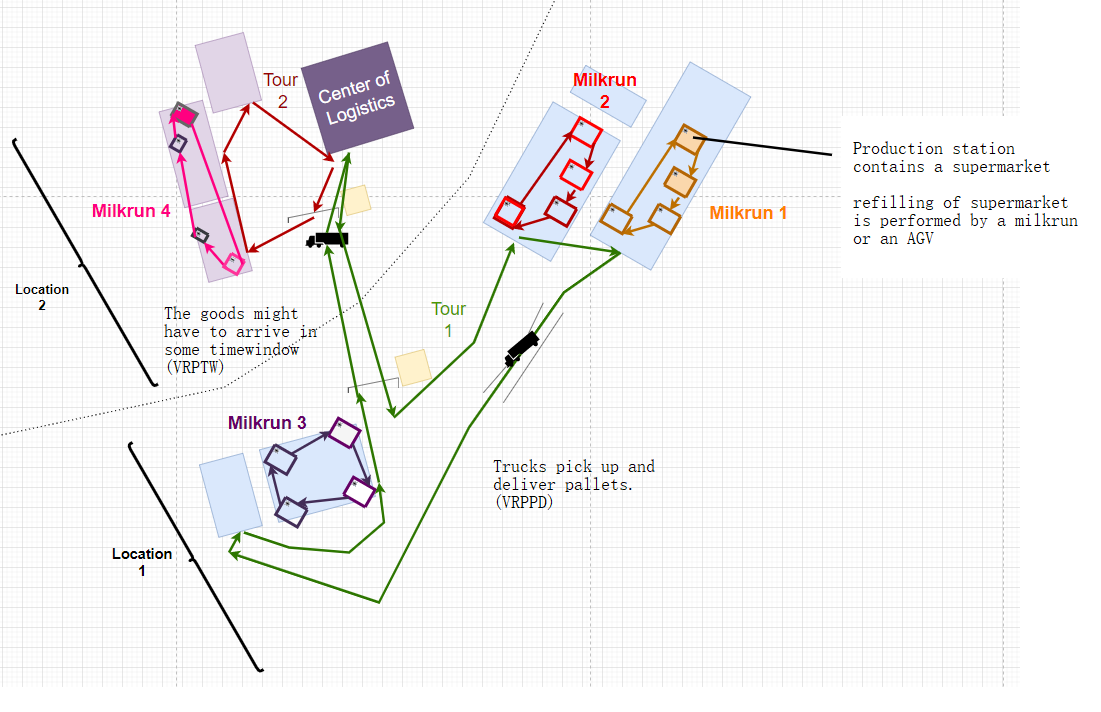

# Optimierung der internen Werkslogistik / Opt. of logistics on factory premisses

flexible planning for variations in transportation requirements


### Thoughts/Problem input:
- Wiederbeschaffungszeit (lead time):
lead time is important because this might mean goods should arrive in time windows e.g. 10-12 16-18 which would lead to an implementation of some timewindow constraints; data: planer decision

- Quantities which need to be loaded and delivered; data: SAP
- Size of the pallets; data: SAP- packaging information

- distances for calculating the best routing:
data: google maps? other?

### We have to make the following decisions:
- Routing of the trucks (order of docking, Anfahrreihenfolge)
- Loading/Unloading Operations


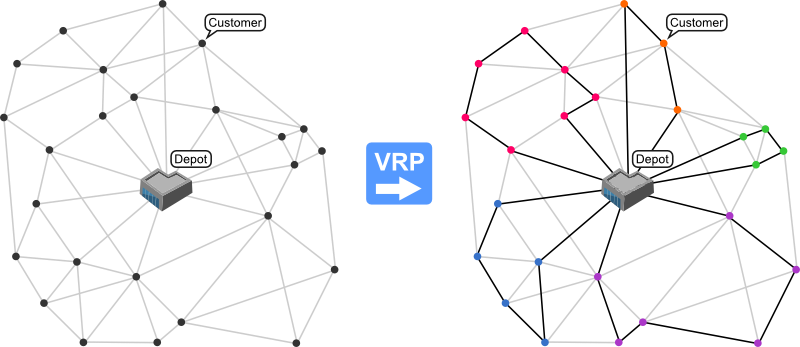

In [14]:
import gurobipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

[https://www.gurobi.com/](https://www.gurobi.com/) A really good optimization software used by companies like toyota, mercedes, basf etc.

## Generating problem instance... lets say we have 10 different locations around the warehouse

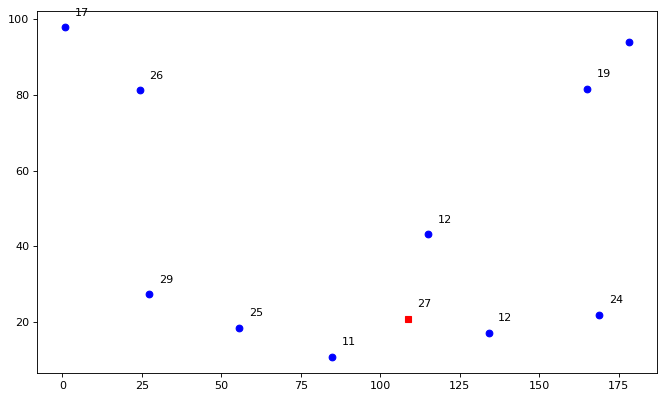

In [15]:
#Input Data
rnd = np.random
rnd.seed(100)
n = 10
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100
N = [i for i in range(1,n+1)]
V = [0] + N
A = [(i,j) for i in V for j in V if i != j]
c = {(i,j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i,j in A}
Q = 50
q = {i: rnd.randint(10,30) for i in N}
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c = 'b')


for i, txt in enumerate(q):
    plt.annotate(q[txt], (xc[i]+3, yc[i]+3))



## Building the mathematical model

In [16]:
from gurobipy import Model, GRB, quicksum
mdl = Model("CVRP")
mdl.setParam('TimeLimit', 30)
x = mdl.addVars(A, vtype=GRB.BINARY)
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(x[a]*c[a] for a in A))

Set parameter TimeLimit to value 30


min! $\sum_{i,j \in \mathcal{A}}  c_{i,j} \cdot x_{i,j}$ 

$\sum_{j \in \mathcal{V}, j \neq i}  x_{i,j} = 1 \;\; \forall i \in N $ 

$\sum_{j \in \mathcal{V}, j \neq i}  x_{i,j} = 1 \;\; \forall j \in N $ 

if $x_{i,j} \rightarrow u_i + q_j = u_j \,\,\, \forall  k \in \mathcal{K} ,t \in \mathcal{T}$

$q_i \leq u_i \leq Q \; \forall i \in N$

$x_{i,j} \in {0,1}$

In [17]:
mdl.addConstrs(quicksum(x[i,j] for j in V if j!=i)== 1 for i in N);
mdl.addConstrs(quicksum(x[i,j] for i in V if j!=i)== 1 for j in N);
mdl.addConstrs((x[i,j] == 1) >> (u[i] + q[i] == u[j])
              for i,j in A if i!=0 and j!=0);
mdl.addConstrs(u[i] >= q[i] for  i in N);
mdl.addConstrs(u[i] <= Q for i in N);

## Perform Solution procedure with gurobi

In [18]:
mdl.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 40 rows, 120 columns and 220 nonzeros
Model fingerprint: 0x45728e45
Model has 90 general constraints
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
  GenCon rhs range [1e+01, 3e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 86 rows and 0 columns
Presolve removed 0 rows and 42 columns
Presolve time: 0.02s
Presolved: 126 rows, 78 columns, 851 nonzeros
Variable types: 15 continuous, 63 integer (63 binary)
Found heuristic solution: objective 1181.4996363

Root relaxation: objective 7.009340e+02, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

In [19]:
active_arcs = [a for a in A if x[a].x > 0.99]

#Coloring every unique route with a different color

def FindEdgeByStartingNode(Node, li):
    for e in li:
        if(e[0] == Node):
            return e

def GetRouteRemoveEdgesFromLi(startingEdge, li): 
    x = startingEdge
    tour = []
    tour.append(startingEdge) 
    while(True):
        x = FindEdgeByStartingNode(x[1], li)
        tour.append(x)
        
        if(x[1] == 0):
            break            
        #li.pop(li.index(x))   
    return tour

numberOfRoutes = 0
for e in active_arcs:
    if(e[0] == 0):
        numberOfRoutes+=1
routes = []

for i in range(0,numberOfRoutes):
    routes.append(GetRouteRemoveEdgesFromLi(active_arcs[i],active_arcs))
    #we get error message when amoutn of routes is less than 3
    
active_arcs = [a for a in A if x[a].x > 0.99]

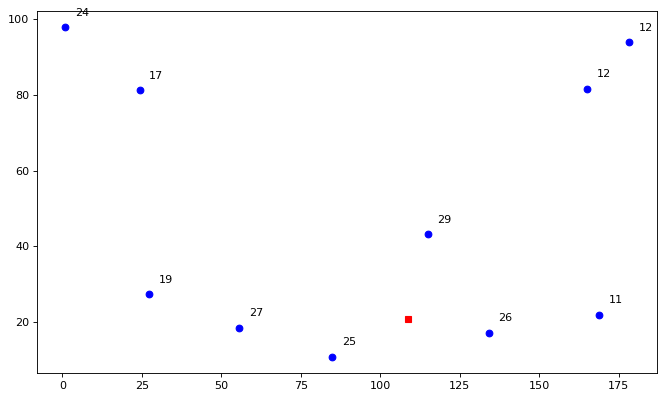

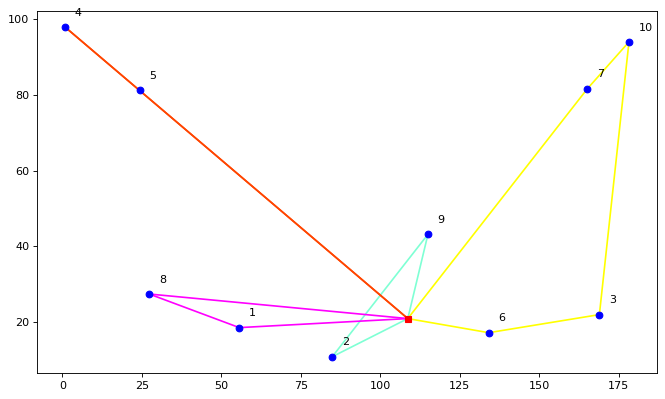

In [20]:
plt.figure(figsize=(10, 6), dpi=80) 
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c = 'b')


for i, txt in enumerate(q):
    plt.annotate(q[txt], (xc[i+1]+3, yc[i+1]+3))

color = ["aquamarine", "orangered", "yellow", "fuchsia",
         "indigo", "springgreen", "red", "navy", "steelblue", "black", "darkgoldenrod"]

plt.figure(figsize=(10, 6), dpi=80) 
for idx, route in enumerate(routes):
    for i,j in route:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c=f'{color[idx]}', zorder=0)
  
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

for i, txt in enumerate(q):
    plt.annotate(txt, (xc[i+1]+3, yc[i+1]+3))
    
    


# Resultat: Routen und die dazugehörigen Streckenabschnitte

In [21]:
routingTable=  pd.DataFrame(routes)
routingTable["color"] = color[0:routingTable.shape[0]]
routingTable

,0,1,2,3,4,color
0,"(0, 2)","(2, 9)","(9, 0)",None,None,aquamarine
1,"(0, 5)","(5, 4)","(4, 0)",None,None,orangered
2,"(0, 7)","(7, 10)","(10, 3)","(3, 6)","(6, 0)",yellow
3,"(0, 8)","(8, 1)","(1, 0)",None,None,fuchsia
